#### En el trabajo realizado se buscó responder a la pregunta: **¿Es posible predecir la concentración de NOx utilizando datos de tránsito vehicular y variables meteorológicas como temperatura, viento y presión?**

Se denomina a los gases N0x como oxidos de nitrogeno derivados de la reaccion de N0 y N02, son producidos de forma antropogénica principalmente en los procesos de combustión en los vehículos motorizados y quema de combustibles fosiles. Para simplificar el analisis se considera como principal gas al N02, ya que el resto son derivados minoritarios.

Este gas tiene una gran relevancia a nivel atmosferico, ya que es un gas de efecto invernadero, ademas de ser toxico y nocivo para la salud.

A partir de datos obtenidos de dos medidores de calidad de aire en CABA se busco determinar si se podra predecir el nivel de N0x atmosferico a partir de flujo vehicular y variables meteorologicas.

Para responder esta pregunta vamos a dividir el analisis en 5 partes:

1. Extraccion y limpieza de Datos

  1.1 Extraccion y limpieza de datos de N02

  1.2 Extracción y limpieza de datos de tránsito

  1.3 Extracción y limpieza de datos climaticos

  1.4 Union de Datasets y consderaciones extra

2.  Aplicacion del modelo

3.  Metricas y resultados del modelo planteado

# 1.  Extracción y limpieza de Datos

## 1.1 Extraccion y limpieza de datos de N02

Se utilizaron como fuente datos dos estaciones de medición del gobierno de la ciudad de Buenos Aires:

**Estación Córdoba**: Av. Córdoba y Rodriguez Peña, releva datos de una zona residencial-comercial con flujo vehicular alto.

**Estación Parque Centenario**: es representativa de una zona residencial-comercial con flujo vehicular medio y próxima a un espacio verde.

Al no estaban disponibles en las paginas oficiales datasets con datos accecibles para su uso, para la obtencion de datos se ingreso a la pagina oficial del gobierno de la ciudad y utilizando un metodo de escrapping se obtuvieron los links de los pdfs, luego se descargan estos pdf en una carpeta temporaria de la cual se extraen las tablas de datos de N02 segun fecha y rango horario, finalmente se concatena toda la infromacion en un dataframe de salida.

In [ ]:
#IMPORTANTE: En caso de que la pagina del gobierno este en mantenimiento, se puede utilizar el dataset utilizando este link:
# df_contaminacion_aire = pd.read_csv("https://github.com/datosbrook44/archivos_tp_final/blob/main/contaminacion_NO2_cordoba_parque.csv")

In [ ]:
#Se importan las librerias y bibliotecas necesarias
!pip install pdfplumber

In [ ]:
import csv
import os
import pdfplumber
import pandas as pd
from itertools import cycle
import requests
from bs4 import BeautifulSoup
import numpy as np
from datetime import datetime
import io


In [ ]:
#creo una carpeta temporaria para los archivos que voy a utilizar.
folder_name = "temp_date"
os.makedirs(folder_name, exist_ok=True)

In [ ]:
#Funcion para descargar los archivos pdf, utilizando el url
def descargar_archivo(url, file_name, folder_name):
    os.makedirs(folder_name, exist_ok=True)

    ruta_archivo = os.path.join(folder_name, file_name)

    response = requests.get(url)

    if response.status_code == 200:
        with open(ruta_archivo, "wb") as f:
            f.write(response.content)
        return ruta_archivo
    else:
        print(f"No se pudo descargar el archivo: {url}")
        return None

In [ ]:
#Funcion para converdir un pdf a un df, pdfplumber es una libreria que permite buscar elementos dentro de un pdf
#extrae la tabla de la primera pagina y la convierte en una tabla retornando un df.

def pdf_to_df(pdf_path):

    with pdfplumber.open(pdf_path) as pdf:
      pagina = pdf.pages[0]
      tablas = pagina.extract_tables()

      if tablas and len(tablas) > 0:
          filas_totales = tablas[0]
          columnas = filas_totales[0]
          datos = filas_totales[1:]
          df = pd.DataFrame(datos, columns=columnas)
          return df
      else:
          print("No se encontraron tablas.")
          return None

In [ ]:
#A partir de la url, año, meses y el indicador (tipo de molecula), utilizando las funciones anteiores, descarga el pdf de la url
# y devuelve un df

def url_to_df(url, year, month, indicator, folder_name):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, "html.parser")

    if month == 'Nov' and year == '2019':
      year = str(int(year)+1)

    if month == 'Dic': #correccion de etiquetas
      year = str(int(year)+1)

    if indicator == 'NOx':
      h3_objetivo = soup.find('h3', string="Datos de Óxidos de Nitrógeno (NO- NO2- NOx)")

      # 2. Recorrer los elementos que vienen después de ese <h3>, hasta el próximo <h3>
      for elem in h3_objetivo.next_siblings:
          if elem.name == 'h3':
              break

          for a in getattr(elem, 'find_all', lambda *args, **kwargs: [])("a", href=True):
              href = a['href']
              texto = a.text.strip()

              if (year in href) and (month in texto):
                  pdf_url = href

                  # Quitar "ash." si está presente
                  if 'ash' in pdf_url:
                      pdf_url = pdf_url.replace("ash.", "")

                  if 'https://buenosaires.gob.ar' not in pdf_url:
                      pdf_url = f'https://buenosaires.gob.ar{pdf_url}'

                  if month =='Dic':
                    file_name = f'{str(int(year)-1)}-{month}-{indicator}.pdf'
                  else:
                    file_name = f'{year}-{month}-{indicator}.pdf'

                  ruta = descargar_archivo(pdf_url, file_name, folder_name)
                  df = pdf_to_df(ruta)

                  return df
              else:
                  continue

In [ ]:
#Aplica la funcion anterior a cada año y mes especificado, devolviendo un df final con toda la infromacion filtrada y en su correcto formato

def df_for_year_indicator(years:list, months:list, url, estacion):
    columns_name = ['Fecha', "Mediciones 0 a 8", "Mediciones 8 a 16", "Mediciones 16 a 24", "Estación"]
    df_final = pd.DataFrame(columns=columns_name)

    for year in years:
      for month in months:
        list_of_31_days = ['Mar','May', 'Jul', 'Ago', 'Oct', 'Dic']

        if month in list_of_31_days:

          days = range(1, 32)

        else:

          days = range(1, 31)

        df = url_to_df(url, year, month, "NOx", folder_name)

        col_inicio = df.columns.get_loc('PROMEDIO 8 HS')
        col_fin = col_inicio + 9

        nuevas_col = df.columns[col_inicio:col_fin]

        df = df.iloc[:, col_inicio:col_fin]

        valor_buscado = 'NO2\n(PPB)'
        mask = df.iloc[1] == valor_buscado

        indices_columnas = [i for i, val in enumerate(mask) if val]
        df = df.iloc[:, indices_columnas]

        df = df[df.index <= 32].iloc[2:]

        columns_name_change = ["Mediciones 0 a 8", "Mediciones 8 a 16", "Mediciones 16 a 24"]

        df.columns.values[0] = columns_name_change[0]
        df.columns.values[1] = columns_name_change[1]
        df.columns.values[2] = columns_name_change[2]

        df = df.reset_index(drop=True)

        for column in columns_name_change:
          valores_numericos = pd.to_numeric(df[column], errors='coerce')
          filtro = valores_numericos.notna() | (df[column] == 's/d')
          df = df[filtro].reset_index(drop=True)

        df.dropna(inplace=True)

        if len(df) == len(days):

          for day in days:

            mes_a_num = {
                'Ene': '01', 'Feb': '02', 'Mar': '03', 'Abr': '04',
                'May': '05', 'Jun': '06', 'Jul': '07', 'Ago': '08',
                'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dic': '12'
            }

            mes_num = mes_a_num.get(month)

            filas_por_agregar = []

            for column in columns_name_change:

              nueva_fila = pd.DataFrame({'Fecha': f'{year}-{mes_num}-{day:02d}', column : [df.loc[day-1, column]], 'Estación': estacion })
              filas_por_agregar.append(nueva_fila)

            for fila in filas_por_agregar:
              fila = fila.dropna(axis=1, how='all')
              df_final = pd.concat([df_final, fila], ignore_index=True)

    return df_final

In [ ]:
#Por falta y baches en los datos en las paginas oficiales, se tuvieron que seleccionar algunos meses en diferentes años

url_parque_centenario = 'https://buenosaires.gob.ar/calidad-del-aire/estacion-parque-centenario'
url_cordoba = 'https://buenosaires.gob.ar/calidad-del-aire/estacion-cordoba'

years = ['2020', '2021', '2022', '2023']

resultados = []

for year in years:
  if year == '2020':
      selected_years = ['2020']
      months = ['Mar','Abr','May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

  elif year == '2021':
      selected_years = ['2021']
      months = ['Ene','Abr']

  elif year == '2022':
      selected_years = ['2022']
      months = ['Ene', 'Feb']

  elif year == '2023':
      selected_years = ['2023']
      months = ['Sep', 'Oct']

  df_parque = df_for_year_indicator(selected_years, months, url_parque_centenario, estacion ='parque-centenario')
  df_cordoba = df_for_year_indicator(selected_years, months, url_cordoba, estacion ='cordoba')

  df_unido = pd.concat([df_parque, df_cordoba], ignore_index=True)
  resultados.append(df_unido)

# Unir todo al final
df_total = pd.concat(resultados, ignore_index=True)
print(df_total)

df_total.to_csv("contaminacion_NO2_cordoba_parque.csv", index=False)

           Fecha Mediciones 0 a 8 Mediciones 8 a 16 Mediciones 16 a 24           Estación
0     2020-03-01               19               NaN                NaN  parque-centenario
1     2020-03-01              NaN                14                NaN  parque-centenario
2     2020-03-01              NaN               NaN                 25  parque-centenario
3     2020-03-02               15               NaN                NaN  parque-centenario
4     2020-03-02              NaN                17                NaN  parque-centenario
5     2020-03-02              NaN               NaN                 25  parque-centenario
6     2020-03-03               16               NaN                NaN  parque-centenario
7     2020-03-03              NaN                13                NaN  parque-centenario
8     2020-03-03              NaN               NaN                 19  parque-centenario
9     2020-03-04               13               NaN                NaN  parque-centenario
10    2020

## 1.2 Extracción y limpieza de datos de tránsito


In [ ]:
#El dataset de Tránsito fue obtenido mediante un request a la api del gobierno de la ciudad de buenos aires, por lo tanto:
#IMPORTANTE: En caso de que no funcione la extraccion de datos correctamente:
# df_transito = pd.read_csv("https://github.com/datosbrook44/archivos_tp_final/blob/main/datos_filtrados_transito_final.csv")

In [ ]:
# Lista de fechas a consultar
fechas = [
    "2020-03", "2020-04", "2020-05", "2020-06",
    "2020-07", "2020-08", "2020-09", "2020-10",
    "2020-11", "2020-12", "2021-01", "2021-04",
    "2022-01", "2022-02", "2023-09", "2023-10"
]

# Autenticación
client_id = "5541aa632c2142b6b6f26196822c2e5d"
client_secret = "ea0065Fa17D34a27a58B5F076ab6B143"

# Lista para almacenar todas las filas
todas_las_filas = []
encabezados = None  # Guardaremos los headers del CSV acá

for anio_mes in fechas:
    url = f"https://apitransporte.buenosaires.gob.ar/datos/movilidad/transito/mensual/{anio_mes}?client_id={client_id}&client_secret={client_secret}"
    response = requests.get(url)

    if response.status_code == 200:
        contenido_csv = io.StringIO(response.text)
        lector = csv.reader(contenido_csv)
        filas = list(lector)

        # Guardar encabezado solo la primera vez
        if encabezados is None:
            encabezados = filas[0]
            todas_las_filas.append(encabezados)

        # Agregar el resto de las filas (omitimos encabezado)
        todas_las_filas.extend(filas[1:])
        print(f"{anio_mes} descargado correctamente.")
    else:
        print(f"Error al descargar {anio_mes}: {response.status_code}")

# Escribir todas las filas en un único archivo CSV
with open("datos_transito_completo.csv", "w", encoding="utf-8", newline='') as f:
    escritor = csv.writer(f)
    escritor.writerows(todas_las_filas)

print("Archivo final guardado como datos_transito_completo.csv")

2020-03 descargado correctamente.
2020-04 descargado correctamente.
2020-05 descargado correctamente.
2020-06 descargado correctamente.
2020-07 descargado correctamente.
2020-08 descargado correctamente.
2020-09 descargado correctamente.
2020-10 descargado correctamente.
2020-11 descargado correctamente.
2020-12 descargado correctamente.
2021-01 descargado correctamente.
2021-04 descargado correctamente.
2022-01 descargado correctamente.
2022-02 descargado correctamente.
2023-09 descargado correctamente.
2023-10 descargado correctamente.
Archivo final guardado como datos_transito_completo.csv


In [ ]:
df_transito = pd.read_csv("datos_transito_completo.csv")
df_transito.head()

,location_code,hora,cantidad,sentido,latitud,longitud
0,48Q39G00+,2020-03-31T23:00:00-0300,66,Interna,-34.633299,-58.468594
1,48Q39G00+,2020-03-31T23:00:00-0300,354,Ingreso,-34.633299,-58.468594
2,48Q39G00+,2020-03-31T23:00:00-0300,434,Egreso,-34.633299,-58.468594
3,48Q39H00+,2020-03-31T23:00:00-0300,433,Interna,-34.618036,-58.410236
4,48Q39J00+,2020-03-31T23:00:00-0300,664,Interna,-34.608550,-58.372951


In [ ]:
#Proceso de limpieza de datos

df_transito = df_transito.rename(columns={'hora': 'timestamp'})
df_transito.head()

,location_code,timestamp,cantidad,sentido,latitud,longitud
0,48Q39G00+,2020-03-31T23:00:00-0300,66,Interna,-34.633299,-58.468594
1,48Q39G00+,2020-03-31T23:00:00-0300,354,Ingreso,-34.633299,-58.468594
2,48Q39G00+,2020-03-31T23:00:00-0300,434,Egreso,-34.633299,-58.468594
3,48Q39H00+,2020-03-31T23:00:00-0300,433,Interna,-34.618036,-58.410236
4,48Q39J00+,2020-03-31T23:00:00-0300,664,Interna,-34.608550,-58.372951


In [ ]:
# Asegurate de que la columna sea tipo datetime
df_transito['timestamp'] = pd.to_datetime(df_transito['timestamp'])

# Crear columna con solo la fecha
df_transito['date'] = df_transito['timestamp'].dt.date

# Crear columna con solo la hora
df_transito['time'] = df_transito['timestamp'].dt.time

df_transito.head()

,location_code,timestamp,cantidad,sentido,latitud,longitud,date,time
0,48Q39G00+,2020-03-31 23:00:00-03:00,66,Interna,-34.633299,-58.468594,2020-03-31,23:00:00
1,48Q39G00+,2020-03-31 23:00:00-03:00,354,Ingreso,-34.633299,-58.468594,2020-03-31,23:00:00
2,48Q39G00+,2020-03-31 23:00:00-03:00,434,Egreso,-34.633299,-58.468594,2020-03-31,23:00:00
3,48Q39H00+,2020-03-31 23:00:00-03:00,433,Interna,-34.618036,-58.410236,2020-03-31,23:00:00
4,48Q39J00+,2020-03-31 23:00:00-03:00,664,Interna,-34.608550,-58.372951,2020-03-31,23:00:00


In [ ]:
df_transito = df_transito.drop(columns=['timestamp'])
df_transito.head()

,location_code,cantidad,sentido,latitud,longitud,date,time
0,48Q39G00+,66,Interna,-34.633299,-58.468594,2020-03-31,23:00:00
1,48Q39G00+,354,Ingreso,-34.633299,-58.468594,2020-03-31,23:00:00
2,48Q39G00+,434,Egreso,-34.633299,-58.468594,2020-03-31,23:00:00
3,48Q39H00+,433,Interna,-34.618036,-58.410236,2020-03-31,23:00:00
4,48Q39J00+,664,Interna,-34.608550,-58.372951,2020-03-31,23:00:00


In [ ]:
#Veo cuantos radares distintos tengo, me quedo con los que me sirven para realizar el analisis pertinente
print(df_transito['latitud'].unique())
print(df_transito['longitud'].unique())

diccionario_ubicacion ={
                        "48Q3CH00+": "Palermo", #Centenario
                        "48Q3CJ00+": "9Julio", #Cordoba
                        "48Q39J00+": "PlazaMayo", #Cordoba
                        "48Q39H00+": "Independencia" #Centenario
                        }

df_transito['ubicacion'] = df_transito['location_code'].map(diccionario_ubicacion)
df_transito.head()


[-34.633299 -34.618036 -34.60855  -34.579632 -34.588796 -34.53698
        nan]
[-58.468594 -58.410236 -58.372951 -58.427733 -58.38152  -58.470968
        nan]


,location_code,cantidad,sentido,latitud,longitud,date,time,ubicacion
0,48Q39G00+,66,Interna,-34.633299,-58.468594,2020-03-31,23:00:00,NaN
1,48Q39G00+,354,Ingreso,-34.633299,-58.468594,2020-03-31,23:00:00,NaN
2,48Q39G00+,434,Egreso,-34.633299,-58.468594,2020-03-31,23:00:00,NaN
3,48Q39H00+,433,Interna,-34.618036,-58.410236,2020-03-31,23:00:00,Independencia
4,48Q39J00+,664,Interna,-34.608550,-58.372951,2020-03-31,23:00:00,PlazaMayo


In [ ]:
df_transito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114975 entries, 0 to 114974
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   location_code  114975 non-null  object 
 1   cantidad       114975 non-null  int64  
 2   sentido        114975 non-null  object 
 3   latitud        114818 non-null  float64
 4   longitud       114818 non-null  float64
 5   date           114975 non-null  object 
 6   time           114975 non-null  object 
 7   ubicacion      74265 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 7.0+ MB


In [ ]:
df_limpio = df_transito.dropna(subset=['ubicacion'])

df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74265 entries, 3 to 114974
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_code  74265 non-null  object 
 1   cantidad       74265 non-null  int64  
 2   sentido        74265 non-null  object 
 3   latitud        74265 non-null  float64
 4   longitud       74265 non-null  float64
 5   date           74265 non-null  object 
 6   time           74265 non-null  object 
 7   ubicacion      74265 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 5.1+ MB


In [ ]:
#Modifico el formato hora para que matchee con el dataset de nox
df_limpio['hora'] = pd.to_datetime(df_limpio['time'], format='%H:%M:%S').dt.time
df_limpio.info()

def asignar_rango_hora(hora):
    if hora < pd.to_datetime("08:00:00").time():
        return "0 a 8"
    elif hora < pd.to_datetime("16:00:00").time():
        return "8 a 16"
    else:
        return "16 a 24"

df_limpio['rango_hora'] = df_limpio['hora'].apply(asignar_rango_hora)
df_limpio.head()

<class 'pandas.core.frame.DataFrame'>
Index: 74265 entries, 3 to 114974
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_code  74265 non-null  object 
 1   cantidad       74265 non-null  int64  
 2   sentido        74265 non-null  object 
 3   latitud        74265 non-null  float64
 4   longitud       74265 non-null  float64
 5   date           74265 non-null  object 
 6   time           74265 non-null  object 
 7   ubicacion      74265 non-null  object 
 8   hora           74265 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.7+ MB


/tmp/ipython-input-167-1154654222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['hora'] = pd.to_datetime(df_limpio['time'], format='%H:%M:%S').dt.time
/tmp/ipython-input-167-1154654222.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['rango_hora'] = df_limpio['hora'].apply(asignar_rango_hora)


,location_code,cantidad,sentido,latitud,longitud,date,time,ubicacion,hora,rango_hora
3,48Q39H00+,433,Interna,-34.618036,-58.410236,2020-03-31,23:00:00,Independencia,23:00:00,16 a 24
4,48Q39J00+,664,Interna,-34.608550,-58.372951,2020-03-31,23:00:00,PlazaMayo,23:00:00,16 a 24
5,48Q3CH00+,186,Interna,-34.579632,-58.427733,2020-03-31,23:00:00,Palermo,23:00:00,16 a 24
6,48Q3CH00+,12,Egreso,-34.579632,-58.427733,2020-03-31,23:00:00,Palermo,23:00:00,16 a 24
7,48Q3CJ00+,124,Ingreso,-34.588796,-58.381520,2020-03-31,23:00:00,9Julio,23:00:00,16 a 24


In [ ]:
#armo un nuevo df con la data que me sirve
df_limpio = df_limpio.groupby(['ubicacion', 'date', 'rango_hora'])['cantidad'].sum().reset_index()

# Renombrar la columna de suma
df_limpio = df_limpio.rename(columns={'cantidad': 'cantidad_total'})
df_limpio.head()

df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ubicacion       5517 non-null   object
 1   date            5517 non-null   object
 2   rango_hora      5517 non-null   object
 3   cantidad_total  5517 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 172.5+ KB


In [ ]:
# Asegurate de que 'date' sea tipo datetime.date o datetime64
df_limpio['date'] = pd.to_datetime(df_limpio['date'])

# Agregar columna booleana 'es_fin_de_semana'
df_limpio['fin_de_semana'] = df_limpio['date'].dt.weekday >= 5
df_limpio.head()

,ubicacion,date,rango_hora,cantidad_total,fin_de_semana
0,9Julio,2020-03-01,0 a 8,11236,True
1,9Julio,2020-03-01,16 a 24,18939,True
2,9Julio,2020-03-01,8 a 16,17128,True
3,9Julio,2020-03-02,0 a 8,30701,False
4,9Julio,2020-03-02,16 a 24,75227,False


In [ ]:
df_limpio = df_limpio.rename(columns={'date': 'fecha'})
df_limpio.head()

,ubicacion,fecha,rango_hora,cantidad_total,fin_de_semana
0,9Julio,2020-03-01,0 a 8,11236,True
1,9Julio,2020-03-01,16 a 24,18939,True
2,9Julio,2020-03-01,8 a 16,17128,True
3,9Julio,2020-03-02,0 a 8,30701,False
4,9Julio,2020-03-02,16 a 24,75227,False


## 1.3 Extracción y limpieza de datos climaticos


El dataset de clima se obtuvo de la plataforma Meteostat (https://meteostat.net/es/station/87585?t=2023-09-01/2023-10-31&utm_source=chatgpt.co) y contiene datos diarios de la Ciudad Autónoma de Buenos Aires. Se utilizaron las columnas fecha, tavg, tmin, tmax, prcp, wspd y pres, que incluyen información sobre la temperatura media, mínima y máxima, precipitaciones, velocidad del viento y presión atmosférica. La columna fecha fue estandarizada para facilitar su integración con los demás datasets del trabajo

In [ ]:
url = "https://raw.githubusercontent.com/datosbrook44/archivos_tp_final/refs/heads/main/clima.csv"
df_clima = pd.read_csv(url)


In [ ]:
df_clima = df_clima.rename(columns={'date': 'Fecha'})
df_clima['Fecha'] = pd.to_datetime(df_clima['Fecha'])
df_clima.head()

,Fecha,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2020-03-01,28.7,24.0,34.0,NaN,NaN,NaN,6.2,NaN,1019.0,NaN
1,2020-03-02,28.6,24.0,34.0,NaN,NaN,NaN,9.4,NaN,1018.9,NaN
2,2020-03-03,27.0,22.5,33.0,NaN,NaN,NaN,8.0,NaN,1016.6,NaN
3,2020-03-04,27.1,22.8,31.9,NaN,NaN,NaN,6.1,NaN,1016.5,NaN
4,2020-03-05,26.1,22.0,32.0,NaN,NaN,NaN,8.1,NaN,1017.9,NaN


In [ ]:
#elimino las col que no me sirven para el analisis o no cuentan con datos suficientes para el mismo
del_col = ["wdir","wpgt","tsun","snow"]

df_clima = df_clima.drop(columns=del_col)
df_clima.head()

,Fecha,tavg,tmin,tmax,prcp,wspd,pres
0,2020-03-01,28.7,24.0,34.0,NaN,6.2,1019.0
1,2020-03-02,28.6,24.0,34.0,NaN,9.4,1018.9
2,2020-03-03,27.0,22.5,33.0,NaN,8.0,1016.6
3,2020-03-04,27.1,22.8,31.9,NaN,6.1,1016.5
4,2020-03-05,26.1,22.0,32.0,NaN,8.1,1017.9


## 1.4 Union de Datasets y consderaciones extra


En esta seccion se combinan los datasets de informacion obtenida anteriormente, para la aproximacion del problema los medidores de transito se van a relacionar con las estaciones de medicion de aire de la siguiente forma:

-Parque Centenario : Palermo e Independencia

-Córdoba: Plaza de Mayo y 9 de Julio


In [ ]:
#dataset de transito
df_transito = df_limpio
df_transito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ubicacion       5517 non-null   object        
 1   fecha           5517 non-null   datetime64[ns]
 2   rango_hora      5517 non-null   object        
 3   cantidad_total  5517 non-null   int64         
 4   fin_de_semana   5517 non-null   bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(2)
memory usage: 177.9+ KB


In [ ]:
#dataset de contaminacion aire
df_contaminacion_aire = df_total
df_contaminacion_aire = df_contaminacion_aire.rename(columns={"Fecha": "fecha"})
df_contaminacion_aire['fecha'] = pd.to_datetime(df_contaminacion_aire['fecha'])
df_contaminacion_aire.head()
df_contaminacion_aire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               2382 non-null   datetime64[ns]
 1   Mediciones 0 a 8    794 non-null    object        
 2   Mediciones 8 a 16   794 non-null    object        
 3   Mediciones 16 a 24  794 non-null    object        
 4   Estación            2382 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 93.2+ KB


In [ ]:
df_clima = df_clima.rename(columns={"Fecha": "fecha"})
df_clima.head()

,fecha,tavg,tmin,tmax,prcp,wspd,pres
0,2020-03-01,28.7,24.0,34.0,NaN,6.2,1019.0
1,2020-03-02,28.6,24.0,34.0,NaN,9.4,1018.9
2,2020-03-03,27.0,22.5,33.0,NaN,8.0,1016.6
3,2020-03-04,27.1,22.8,31.9,NaN,6.1,1016.5
4,2020-03-05,26.1,22.0,32.0,NaN,8.1,1017.9


In [ ]:
#Funcion para obtener un df final, relacionando los rangos horarios

def unir_df(df_transito, df_contaminacion_aire):
    df_nuevo = pd.DataFrame(columns=[
        'rango_hora', 'ubicacion', 'fecha', 'cantidad_total',
        'Mediciones 0 a 8', 'Mediciones 8 a 16', 'Mediciones 16 a 24', 'estacion', 'fin_de_semana'
    ])

    columns_name = ['Mediciones 0 a 8', 'Mediciones 8 a 16', 'Mediciones 16 a 24']
    valores_objetivo = ['0 a 8', '8 a 16', '16 a 24']

    for columna, rango in zip(columns_name, valores_objetivo):
        for _, fila in df_transito.iterrows():
            if fila['rango_hora'] == rango:
                df_filtrado = df_contaminacion_aire[df_contaminacion_aire['fecha'] == fila['fecha']]
                df_valida = df_filtrado[pd.notna(df_filtrado[columna])]

                if not df_valida.empty:
                  for _, fila_contaminacion in df_valida.iterrows():
                      nueva_fila = {
                          'rango_hora': fila['rango_hora'],
                          'ubicacion': fila['ubicacion'],
                          'fecha': fila['fecha'],
                          'cantidad_total': fila['cantidad_total'],
                          columna : fila_contaminacion[columna],
                          'fin_de_semana': fila['fin_de_semana'],
                          'estacion': fila_contaminacion['Estación'] if 'Estación' in fila_contaminacion else ''
                      }
                      df_nuevo = pd.concat([df_nuevo, pd.DataFrame([nueva_fila])], ignore_index=True)

    return df_nuevo
df_final = unir_df(df_transito, df_contaminacion_aire)
print(df_final.head())

/tmp/ipython-input-177-2309250113.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nuevo = pd.concat([df_nuevo, pd.DataFrame([nueva_fila])], ignore_index=True)


  rango_hora ubicacion      fecha cantidad_total Mediciones 0 a 8 Mediciones 8 a 16 Mediciones 16 a 24           estacion fin_de_semana
0      0 a 8    9Julio 2020-03-01          11236               19               NaN                NaN  parque-centenario          True
1      0 a 8    9Julio 2020-03-01          11236               14               NaN                NaN            cordoba          True
2      0 a 8    9Julio 2020-03-02          30701               15               NaN                NaN  parque-centenario         False
3      0 a 8    9Julio 2020-03-02          30701               10               NaN                NaN            cordoba         False
4      0 a 8    9Julio 2020-03-03          29626               16               NaN                NaN  parque-centenario         False


In [ ]:
#la relacion entre medidor de nox y radares vehiculares
coincidencias = {
    'parque-centenario': ['Palermo', 'Independencia'],
    'cordoba': ['PlazaMayo', '9Julio'],
}

In [ ]:
df_filtrado = df_final[
    (
        (df_final['estacion'] == 'cordoba') &
        (df_final['ubicacion'].isin(['9Julio', 'PlazaMayo']))
    ) |
    (
        (df_final['estacion'] == 'parque-centenario') &
        (df_final['ubicacion'].isin(['Independencia', 'Palermo']))
    )
]

In [ ]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4461 entries, 1 to 8921
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rango_hora          4461 non-null   object        
 1   ubicacion           4461 non-null   object        
 2   fecha               4461 non-null   datetime64[ns]
 3   cantidad_total      4461 non-null   object        
 4   Mediciones 0 a 8    1485 non-null   object        
 5   Mediciones 8 a 16   1491 non-null   object        
 6   Mediciones 16 a 24  1485 non-null   object        
 7   estacion            4461 non-null   object        
 8   fin_de_semana       4461 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 348.5+ KB


In [ ]:
df_final = pd.merge(df_filtrado, df_clima, on='fecha')
df_final.head()

,rango_hora,ubicacion,fecha,cantidad_total,Mediciones 0 a 8,Mediciones 8 a 16,Mediciones 16 a 24,estacion,fin_de_semana,tavg,tmin,tmax,prcp,wspd,pres
0,0 a 8,9Julio,2020-03-01,11236,14,NaN,NaN,cordoba,True,28.7,24.0,34.0,NaN,6.2,1019.0
1,0 a 8,9Julio,2020-03-02,30701,10,NaN,NaN,cordoba,False,28.6,24.0,34.0,NaN,9.4,1018.9
2,0 a 8,9Julio,2020-03-03,29626,11,NaN,NaN,cordoba,False,27.0,22.5,33.0,NaN,8.0,1016.6
3,0 a 8,9Julio,2020-03-04,30790,9,NaN,NaN,cordoba,False,27.1,22.8,31.9,NaN,6.1,1016.5
4,0 a 8,9Julio,2020-03-05,31196,8,NaN,NaN,cordoba,False,26.1,22.0,32.0,NaN,8.1,1017.9


In [ ]:
# Voy a crear una nueva columna 'nox_medido' con el valor de la columna correcta según rango_hora
def extraer_nox(row):
    if row['rango_hora'] == '0 a 8':
        return row['Mediciones 0 a 8']
    elif row['rango_hora'] == '8 a 16':
        return row['Mediciones 8 a 16']
    else:
        return row['Mediciones 16 a 24']

df_final['nox_medido'] = df_final.apply(extraer_nox, axis=1)

# elimino las columnas originales
df_final = df_final.drop(columns=['Mediciones 0 a 8', 'Mediciones 8 a 16', 'Mediciones 16 a 24'])
df_final.head()

,rango_hora,ubicacion,fecha,cantidad_total,estacion,fin_de_semana,tavg,tmin,tmax,prcp,wspd,pres,nox_medido
0,0 a 8,9Julio,2020-03-01,11236,cordoba,True,28.7,24.0,34.0,NaN,6.2,1019.0,14
1,0 a 8,9Julio,2020-03-02,30701,cordoba,False,28.6,24.0,34.0,NaN,9.4,1018.9,10
2,0 a 8,9Julio,2020-03-03,29626,cordoba,False,27.0,22.5,33.0,NaN,8.0,1016.6,11
3,0 a 8,9Julio,2020-03-04,30790,cordoba,False,27.1,22.8,31.9,NaN,6.1,1016.5,9
4,0 a 8,9Julio,2020-03-05,31196,cordoba,False,26.1,22.0,32.0,NaN,8.1,1017.9,8


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4461 entries, 0 to 4460
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   rango_hora      4461 non-null   object        
 1   ubicacion       4461 non-null   object        
 2   fecha           4461 non-null   datetime64[ns]
 3   cantidad_total  4461 non-null   object        
 4   estacion        4461 non-null   object        
 5   fin_de_semana   4461 non-null   object        
 6   tavg            4461 non-null   float64       
 7   tmin            4461 non-null   float64       
 8   tmax            4461 non-null   float64       
 9   prcp            693 non-null    float64       
 10  wspd            4461 non-null   float64       
 11  pres            4461 non-null   float64       
 12  nox_medido      4461 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 453.2+ KB


In [ ]:
# Buscar valores 's/d' en todo el DataFrame para evitar missing data colgada
mask_sd = df_final.isin(['s/d'])

# Total de ocurrencias
total_sd = mask_sd.sum().sum()
print(f"Total de 's/d' en el DataFrame: {total_sd}")

# Número de 's/d' por columna
print("\nCantidad de 's/d' por columna:")
print(mask_sd.sum())

Total de 's/d' en el DataFrame: 228

Cantidad de 's/d' por columna:
rango_hora          0
ubicacion           0
fecha               0
cantidad_total      0
estacion            0
fin_de_semana       0
tavg                0
tmin                0
tmax                0
prcp                0
wspd                0
pres                0
nox_medido        228
dtype: int64


In [ ]:
df_final['nox_medido'] = pd.to_numeric(df_final['nox_medido'], errors='coerce')  # Convierte 's/d' a NaN
df_final['nox_medido'].fillna(df_final['nox_medido'].median(), inplace=True)


/tmp/ipython-input-185-2004412633.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['nox_medido'].fillna(df_final['nox_medido'].median(), inplace=True)


In [ ]:
import holidays

#encontre esta libreria que te determina si una fecha es feriado o no, lo cual tiene cierta implicancia a la hora de analizar el transito

# Crear el calendario de feriados argentinos
feriados_ar = holidays.AR(years=range(2020, 2021))

# Para un DataFrame
df_final['es_feriado'] = df_final['fecha'].isin(feriados_ar)


/tmp/ipython-input-186-240222367.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_final['es_feriado'] = df_final['fecha'].isin(feriados_ar)


In [ ]:
# df_final.drop('prcp', axis=1, inplace=True)


# # Mostrar todas las columnas
# pd.set_option('display.max_columns', None)

# print(df_final.head(7))

In [ ]:

# df_final = df_final.rename(columns={'cantidad_total': 'cantidad_vehiculos'})

# df_final = df_final.rename(columns={'wspd': 'velocidad_viento'})


# df_final = df_final.rename(columns={'ubicacion': 'avenida'})

# df_final = df_final.rename(columns={'estacion': 'estacion_calidad_aire'})



In [ ]:
# # # Mostrar todas las columnas
# pd.set_option('display.max_columns', None)

# # Mostrar todas las filas (cuidado si tenés muchas)
# pd.set_option('display.max_rows', None)

# # Ajustar el ancho de las columnas para que no se trunquen
# pd.set_option('display.max_colwidth', None)

# # Para evitar el corte horizontal
# pd.set_option('display.expand_frame_repr', False)

# print(df_final.head(7))

In [ ]:
print(len(df_final))

4461


In [ ]:
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4461 entries, 0 to 4460
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   rango_hora      4461 non-null   object        
 1   ubicacion       4461 non-null   object        
 2   fecha           4461 non-null   datetime64[ns]
 3   cantidad_total  4461 non-null   object        
 4   estacion        4461 non-null   object        
 5   fin_de_semana   4461 non-null   object        
 6   tavg            4461 non-null   float64       
 7   tmin            4461 non-null   float64       
 8   tmax            4461 non-null   float64       
 9   prcp            693 non-null    float64       
 10  wspd            4461 non-null   float64       
 11  pres            4461 non-null   float64       
 12  nox_medido      4461 non-null   float64       
 13  es_feriado      4461 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(7), object(5)
mem

## 2. Aplicacion del modelo

La implementación del modelo consistió en construir un pipeline en Python utilizando la librería scikit-learn. Se prepararon las variables numéricas mediante estandarización y las categóricas mediante codificación one-hot. El modelo seleccionado fue un Random Forest Regressor, elegido por su capacidad para manejar relaciones no lineales y datos con diferentes escalas. El entrenamiento se realizó con un conjunto de datos compuesto por información de tráfico, clima y calidad del aire, segmentado por rango horario y ubicación. Finalmente, se evaluó el desempeño del modelo utilizando métricas como el R² y el error absoluto medio (MAE), obteniendo resultados satisfactorios para la predicción de los niveles de NOx en la Ciudad de Buenos Aires.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Features y target
X = df_final.drop(columns=['nox_medido', 'fecha'])  # Quitamos la fecha y target
y = df_final['nox_medido']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Columnas categóricas y numéricas
cat_features = ['ubicacion', 'rango_hora', 'estacion']
num_features = ['cantidad_total', 'tavg', 'tmin', 'tmax', 'fin_de_semana', 'wspd', 'pres','es_feriado']

# Transformadores
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Modelo
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)

# Pipeline completo
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', rf_model)
])


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Entrenar
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAE: 3.85
R²: 0.77


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print(scores)

[0.72400694 0.84535295 0.1732988  0.7887162  0.62204703]


## 3.Metricas y resultados del modelo planteado

La evaluación del modelo incluyó tanto métricas como visualizaciones para analizar su desempeño y la relación entre las variables. Se utilizaron el coeficiente de determinación (R²) y el error absoluto medio (MAE) como métricas principales, obteniendo un R² de 0.64 y un MAE de 3.59, lo que indica un buen ajuste considerando la complejidad del fenómeno. Para complementar, se generaron gráficos comparando los valores predichos y reales de NOx, mostrando una buena alineación en la mayoría de los casos. También se analizaron los niveles de NOx en función del tráfico, la temperatura media y la velocidad del viento, observándose tendencias claras en relación con estas variables. Se evaluaron las diferencias entre días de semana y fines de semana, así como las fluctuaciones en la cantidad de vehículos por fecha, destacando patrones asociados a la actividad humana. Finalmente, se incluyó un análisis de la presión atmosférica, concluyendo que su influencia sobre los niveles de NOx es menor en comparación con otras variables.

In [ ]:
## a continuacion se ralizaran visualizaciones, para las cuales la variable fecha sera considerada
## debido a las complicaciones a la hora de obtener la data, esta variable no es lineal, y por lo tanto
## para facilitarnos la visualizacion se opto por acotar el dataframe en el rango lineal que tenemos
## aun asi el analisis esta hecho con la mayoria de los datos del dataframe

df = df_final.copy()
df['nox_predicho'] = pipeline.predict(X)
df = df[df['fecha'] <= '2021-01-31']


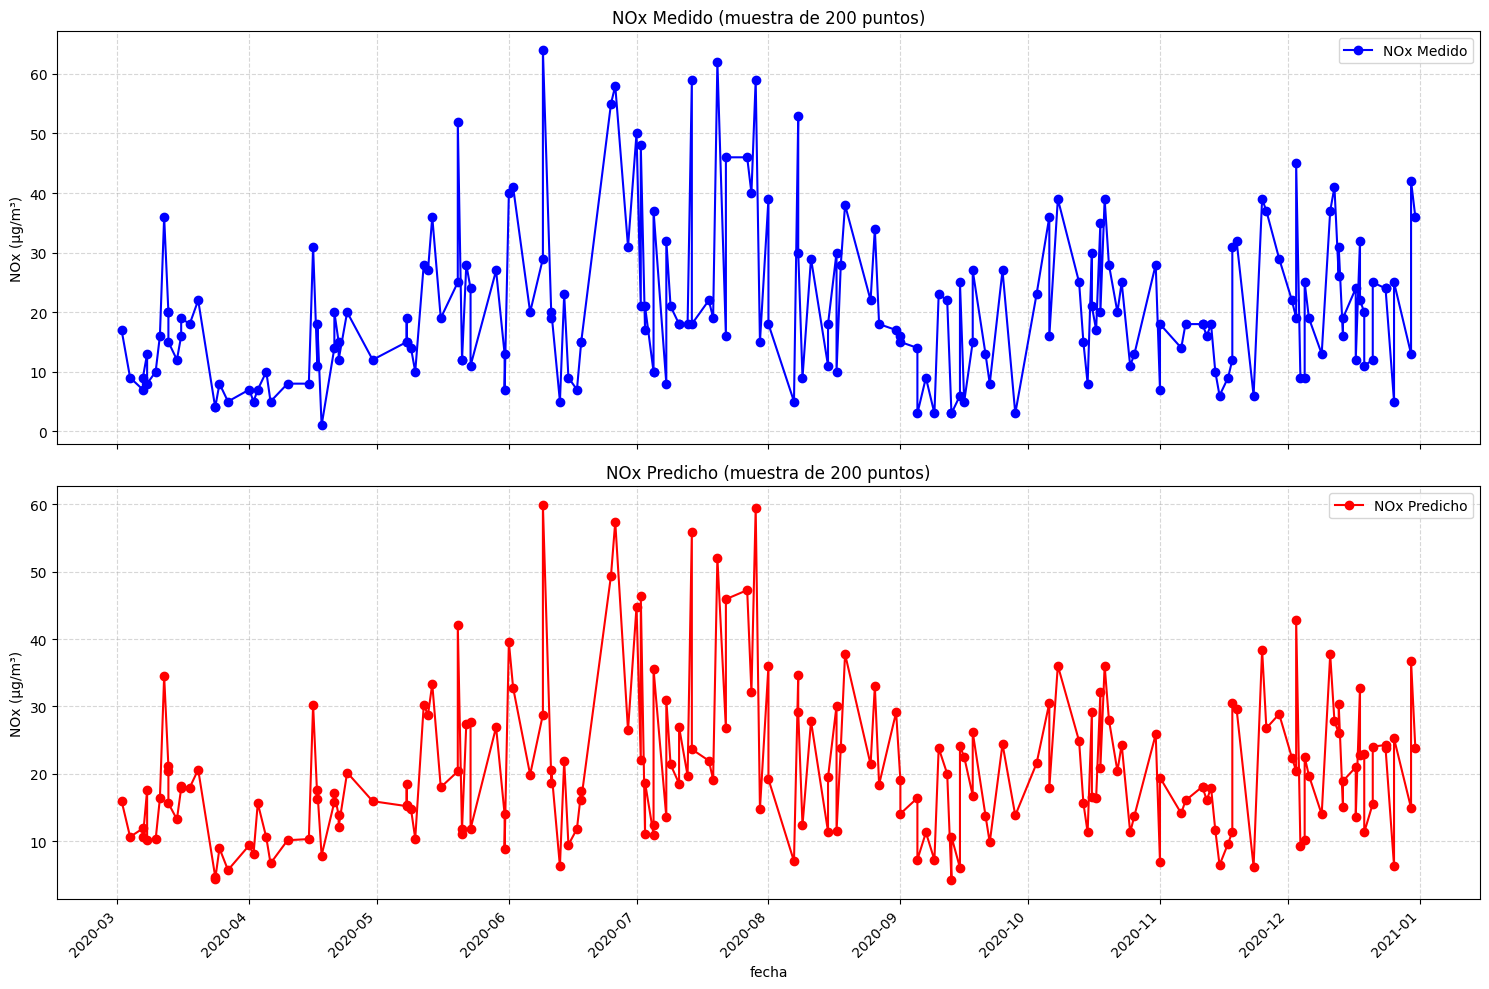

In [ ]:
import matplotlib.pyplot as plt

def plot_sample_separated(df, sample_size=500, random_state=None):
    """
    Grafica NOx medido y NOx predicho en dos subplots separados usando una muestra aleatoria.

    Args:
        df: DataFrame con columnas 'fecha', 'nox_medido', 'nox_predicho'
        sample_size: cantidad de puntos a graficar
        random_state: semilla para reproducibilidad
    """
    # Tomar muestra aleatoria y ordenar por fecha
    sample = df.sample(n=sample_size, random_state=random_state).sort_values('fecha')

    # Crear figura con 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(15,10), sharex=True)

    # NOx Medido
    axes[0].plot(sample['fecha'], sample['nox_medido'], color='blue', marker='o', linestyle='-', label='NOx Medido')
    axes[0].set_title(f'NOx Medido (muestra de {sample_size} puntos)')
    axes[0].set_ylabel('NOx (µg/m³)')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # NOx Predicho
    axes[1].plot(sample['fecha'], sample['nox_predicho'], color='red', marker='o', linestyle='-', label='NOx Predicho')
    axes[1].set_title(f'NOx Predicho (muestra de {sample_size} puntos)')
    axes[1].set_xlabel('fecha')
    axes[1].set_ylabel('NOx (µg/m³)')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # Ajustes finales
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_sample_separated(df, sample_size=200, random_state=42)

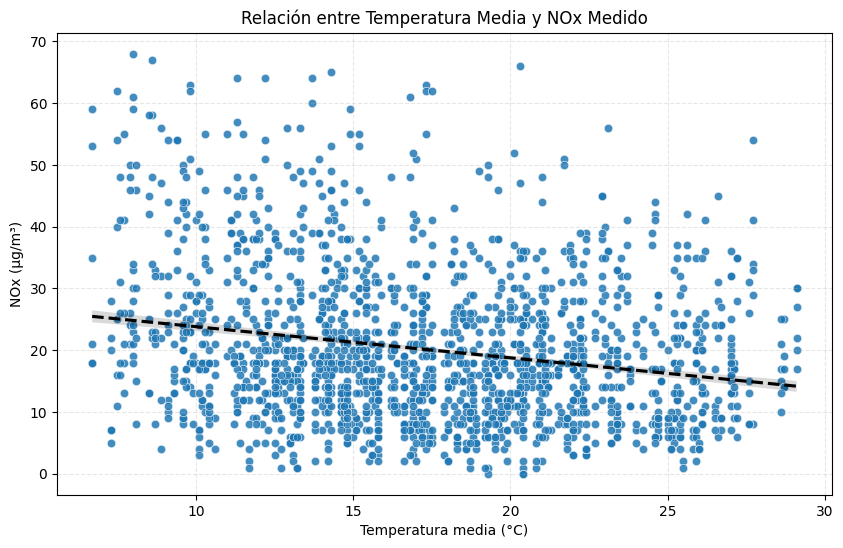

In [ ]:
#grafico de temperatura media y nox medido

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
sns.scatterplot(x='tavg', y='nox_medido', data=df, alpha=0.6)
sns.regplot(x='tavg', y='nox_medido', data=df, scatter=False, color='black', line_kws={'linestyle':'--'})
plt.title('Relación entre Temperatura Media y NOx Medido')
plt.xlabel('Temperatura media (°C)')
plt.ylabel('NOx (µg/m³)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar cantidad_total
scaler = MinMaxScaler()
df['cantidad_total_norm'] = scaler.fit_transform(df[['cantidad_total']])


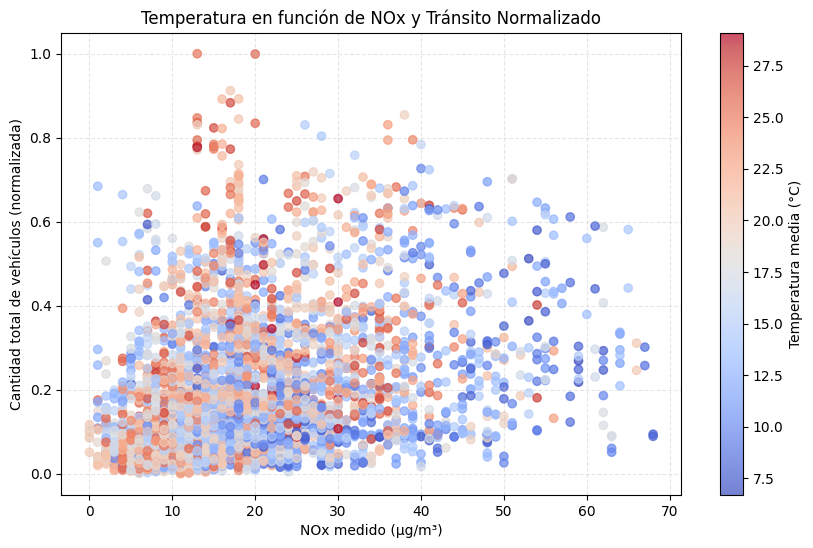

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Scatter plot con color basado en temperatura media
scatter = plt.scatter(
    df['nox_medido'],
    df['cantidad_total_norm'],
    c=df['tavg'],
    cmap='coolwarm',
    alpha=0.7
)

# Barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Temperatura media (°C)')

# Labels y título
plt.title('Temperatura en función de NOx y Tránsito Normalizado')
plt.xlabel('NOx medido (µg/m³)')
plt.ylabel('Cantidad total de vehículos (normalizada)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


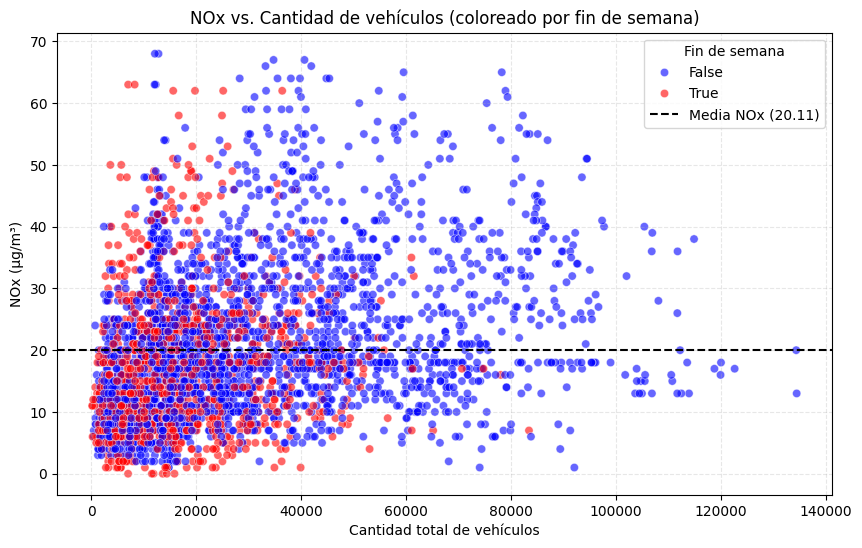

In [ ]:
#grafico de nox vs cantidad de vehiculos discriminado por fin de semana

"""
El gráfico muestra una relación positiva entre la cantidad de vehículos y los niveles de NOx,
destacándose que los días hábiles concentran mayores valores en comparación con los fines de semana.
"""



plt.figure(figsize=(10,6))

# Scatter plot
sns.scatterplot(
    x='cantidad_total', y='nox_medido', hue='fin_de_semana',
    palette={True: 'red', False: 'blue'}, alpha=0.6, data=df
)

# Línea punteada con la media de NOx
nox_mean = df['nox_medido'].mean()
plt.axhline(y=nox_mean, color='black', linestyle='--', linewidth=1.5, label=f'Media NOx ({nox_mean:.2f})')

# Detalles
plt.title('NOx vs. Cantidad de vehículos (coloreado por fin de semana)')
plt.xlabel('Cantidad total de vehículos')
plt.ylabel('NOx (µg/m³)')
plt.legend(title='Fin de semana')
plt.grid(True, linestyle='--', alpha=0.3)

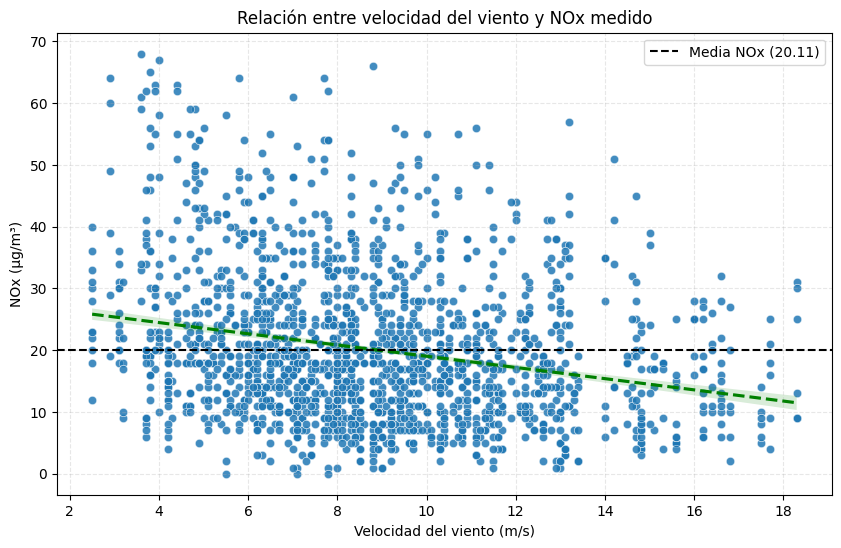

In [ ]:
#grafico de nox vs velocidad del viento

"""
Se identifica una disminución de los niveles de NOx a medida que aumenta la velocidad del viento,
lo que evidencia el efecto de dispersión de contaminantes en días ventosos.
"""
plt.figure(figsize=(10,6))

# Scatter plot NOx vs. velocidad del viento
sns.scatterplot(
    x='wspd', y='nox_medido', data=df, alpha=0.6
)

# Línea de tendencia (regresión lineal simple)
sns.regplot(
    x='wspd', y='nox_medido', data=df, scatter=False,
    color='green', line_kws={'linestyle':'--'}
)

# Media de NOx como línea horizontal
nox_mean = df['nox_medido'].mean()
plt.axhline(y=nox_mean, color='black', linestyle='--', linewidth=1.5, label=f'Media NOx ({nox_mean:.2f})')

# Detalles
plt.title('Relación entre velocidad del viento y NOx medido')
plt.xlabel('Velocidad del viento (m/s)')
plt.ylabel('NOx (µg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

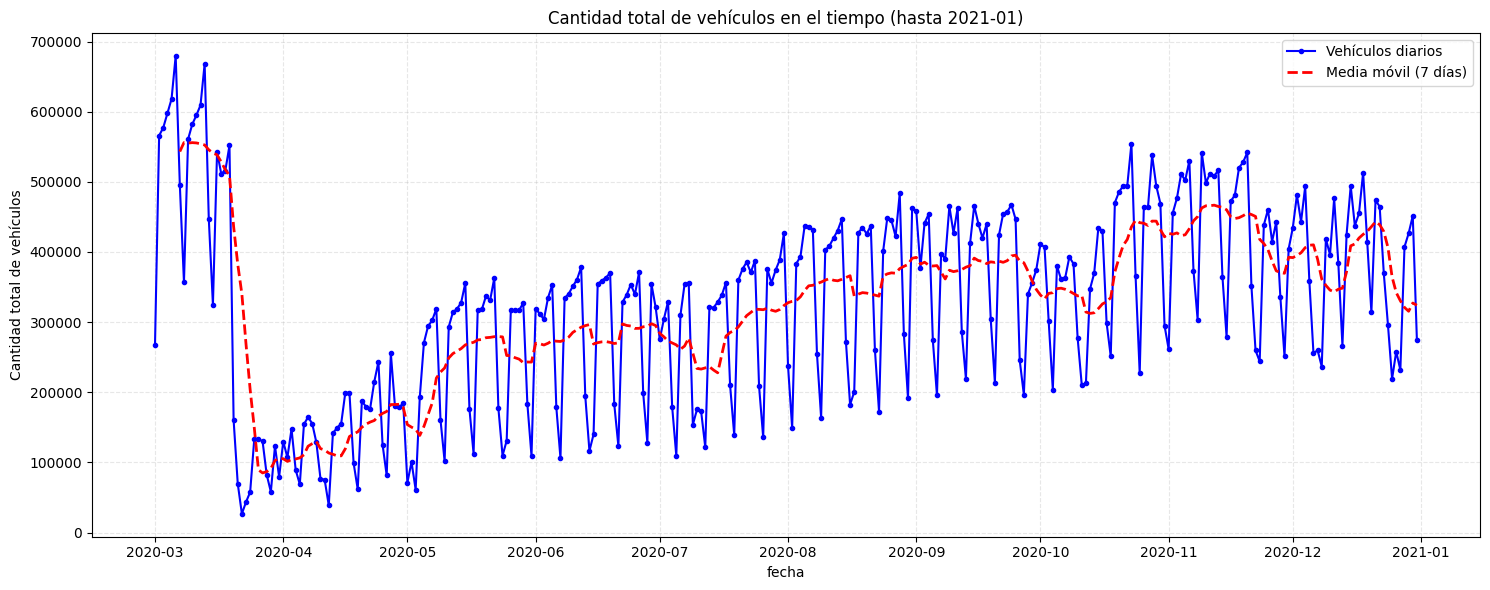

In [ ]:
#grafico de cantidad de vehiculos en el tiempo

"""
La serie temporal refleja fluctuaciones claras en el tránsito,
con descensos marcados durante los fines de semana y patrones consistentes a lo largo de los meses analizados.
"""

# Crear rango completo de fechas hasta 2021-01
full_range = pd.date_range(start=df['fecha'].min(), end='2021-01-31')

# Agrupar datos y reindexar para incluir fechas faltantes
df_vehiculos = df.groupby('fecha')['cantidad_total'].sum().reindex(full_range).reset_index()
df_vehiculos.columns = ['fecha', 'cantidad_total']

# Plot
plt.figure(figsize=(15,6))
plt.plot(df_vehiculos['fecha'], df_vehiculos['cantidad_total'], color='blue', linestyle='-', marker='o', markersize=3, label='Vehículos diarios')

# Media móvil para suavizar
df_vehiculos['media_movil_7d'] = df_vehiculos['cantidad_total'].rolling(window=7).mean()
plt.plot(df_vehiculos['fecha'], df_vehiculos['media_movil_7d'], color='red', linestyle='--', linewidth=2, label='Media móvil (7 días)')

# Detalles
plt.title('Cantidad total de vehículos en el tiempo (hasta 2021-01)')
plt.xlabel('fecha')
plt.ylabel('Cantidad total de vehículos')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

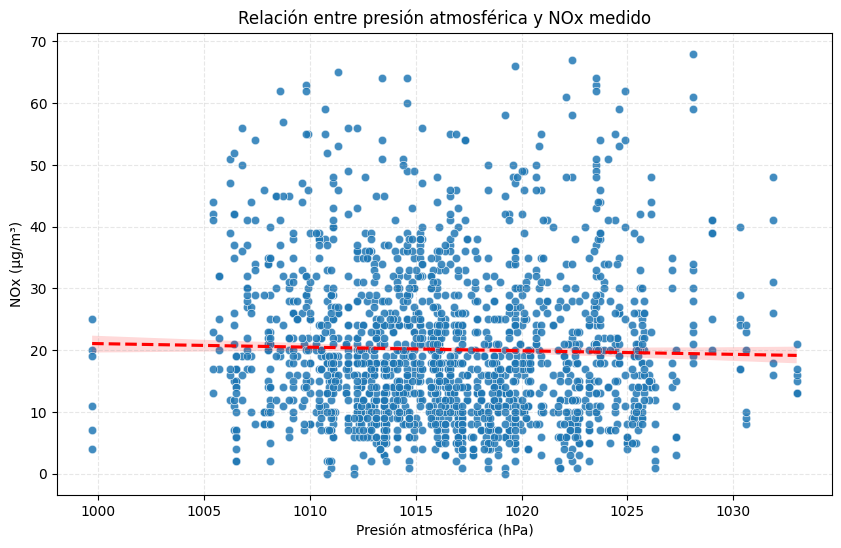

In [ ]:
#grafico de nox vs presion atmosferica

"""
No se aprecia una relación significativa entre la presión atmosférica y las concentraciones de NOx,
sugiriendo un impacto limitado de esta variable sobre la calidad del aire.
"""

plt.figure(figsize=(10,6))
sns.scatterplot(x='pres', y='nox_medido', data=df, alpha=0.6)
sns.regplot(x='pres', y='nox_medido', data=df, scatter=False, color='red', line_kws={'linestyle':'--'})
plt.title('Relación entre presión atmosférica y NOx medido')
plt.xlabel('Presión atmosférica (hPa)')
plt.ylabel('NOx (µg/m³)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
